In [ ]:
import os
import sys
import numpy as np

from keras.models import Model, load_model
from keras.layers import Input,  BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K

import tensorflow as tf

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 123
tf.random.set_seed(SEED)  

cwd = os.getcwd()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect',
                                      rescale=1./255,
                                      validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect',
                                       validation_split=0.2)
else:
    train_img_data_gen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(validation_split=0.2)

# Create validation ImageDataGenerator objects
valid_img_data_gen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
valid_mask_data_gen = ImageDataGenerator(validation_split=0.2)

# Create generators to read images from dataset directory
# -------------------------------------------------------

dataset_dir = '/content/drive/My Drive/AN2DL/Challenge2/Bip/Training256'
# Batch size
bs = 16

# img shape
img_h = 256
img_w = 256
num_classes=3

# Training
# Two different generators for images and masks but with same seed
training_dir = os.path.join(dataset_dir, 'Mais') #here put 'Haricot' to train on haricot dataset
train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'Images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs,
                                                       class_mode=None, 
                                                       shuffle=True,
                                                       interpolation='bilinear',
                                                       seed=SEED,
                                                       subset='training')  
train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'Masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs,
                                                         class_mode=None,
                                                         shuffle=True,
                                                         interpolation='nearest',
                                                         seed=SEED,
                                                         subset='training')
train_gen = zip(train_img_gen, train_mask_gen)

# Validation
valid_img_gen = valid_img_data_gen.flow_from_directory(os.path.join(training_dir, 'Images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, 
                                                       shuffle=True,
                                                       interpolation='bilinear',
                                                       seed=SEED,
                                                       subset='validation')
valid_mask_gen = valid_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'Masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs, 
                                                         class_mode=None,
                                                         shuffle=True,
                                                         interpolation='nearest',
                                                         seed=SEED,
                                                         subset='validation')
valid_gen = zip(valid_img_gen, valid_mask_gen)

Found 3456 images belonging to 1 classes.
Found 3456 images belonging to 1 classes.
Found 864 images belonging to 1 classes.
Found 864 images belonging to 1 classes.


In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None,img_h, img_w, 3], [None,img_h, img_w,3]))


def prepare_target(x_, y_):
  # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target labels 256 x 256 x 1
  #[254, 124, 18] = 0 done implicitly with the first cast
  #[255, 255, 255]= 1 done with the first cast
  #[216, 67, 82]= 2 done with the second cast that is multiplied by 2
    output=tf.cast(tf.reduce_all(y_== [255, 255, 255], axis=-1, keepdims=True), tf.float32)
    output=output+2*tf.cast(tf.reduce_all(y_== [216, 67, 82], axis=-1, keepdims=True), tf.float32)
    return x_, output

train_dataset = train_dataset.map(prepare_target)


train_dataset = train_dataset.repeat()



valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None,img_h, img_w, 3], [None,img_h, img_w,3]))
valid_dataset = valid_dataset.map(prepare_target)


valid_dataset = valid_dataset.repeat()

[0. 2.]


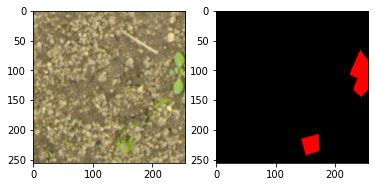

In [ ]:
# Let's test data generator for a check
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = np.array(augmented_img[0])   # First element
augmented_img = augmented_img *255 # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)
print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [ ]:
#Unet model using Keras functional API and skip connections

inputs = Input((256,256,3))

Conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
Dp1 = Dropout(0.1) (Conv1)
Bn1 = BatchNormalization()(Dp1)
Conv_bis1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Bn1)
Pool1 = MaxPooling2D((2, 2)) (Conv_bis1)

Conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Pool1)
Dp2 = Dropout(0.1) (Conv2)
Bn2 = BatchNormalization()(Dp2)
Conv_bis2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Bn2)
Pool2 = MaxPooling2D((2, 2)) (Conv_bis2)

Conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Pool2)
Dp3 = Dropout(0.2) (Conv3)
Bn3 = BatchNormalization()(Dp3)
Conv_bis3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Bn3)
Pool3 = MaxPooling2D((2, 2)) (Conv_bis3)

Conv4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Pool3)
Dp4 = Dropout(0.2) (Conv4)
Bn4 = BatchNormalization()(Dp4)
Conv_bis4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Bn4)
Pool4 = MaxPooling2D(pool_size=(2, 2)) (Conv_bis4)


Conv5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Pool4)
Dp5 = Dropout(0.2) (Conv5)
Bn5 = BatchNormalization()(Dp5)
Conv_bis5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Bn5)
Pool5 = MaxPooling2D(pool_size=(2, 2)) (Conv_bis5)

#bottleneck
Conv_bottleneck = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Pool5)
Dp_bottleneck = Dropout(0.3) (Conv_bottleneck)
Bn_bottleneck = BatchNormalization()(Dp_bottleneck)
Conv_bis_bottleneck = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Bn_bottleneck)

Up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (Conv_bis_bottleneck)
Up6 = concatenate([Up6, Conv_bis5])
Conv6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Up6)
Dp6 = Dropout(0.2) (Conv6)
Bn6 = BatchNormalization()(Dp6)
Conv_bis6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Bn6)

Up7=Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (Conv_bis6)
Up7 = concatenate([Up7, Conv_bis4])
Conv7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Up7)
Dp7 = Dropout(0.2) (Conv7)
Bn7 = BatchNormalization()(Dp7)
Conv_bis7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Bn7)

Up8=Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (Conv_bis7)
Up8 = concatenate([Up8, Conv_bis3])
Conv8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Up8)
Dp8 = Dropout(0.2) (Conv8)
Bn8 = BatchNormalization()(Dp8)
Conv_bis8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Bn8)
              kernel_size=(1, 1),

Up9=Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (Conv_bis8)
Up9 = concatenate([Up9, Conv_bis2])
Conv9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Up9)
Dp9 = Dropout(0.2) (Conv9)
Bn9 = BatchNormalization()(Dp9)
Conv_bis9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Bn9)

Up10=Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (Conv_bis9)
Up10 = concatenate([Up10, Conv_bis1])
Conv10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Up10)
Dp10 = Dropout(0.2) (Conv10)
Bn10 = BatchNormalization()(Dp10)
Conv_bis10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (Bn10)

outputs=Conv2D(filters=3,
              strides=(1, 1),
              padding='same',
              activation='softmax')(Conv_bis10)
model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         dropout[0][0]                    
_______________________________________________________________________________________

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
#training with callbacks

# Early Stopping
# --------------
early_stop = True
if early_stop:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
callbacks.append(es_callback)

# Learning rate adapter
# --------------
lr_adapter = True
if lr_adapter:
  lr_adapter_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.2,
                                                             patience=7,
                                                             verbose=1,
                                                             mode='auto',
                                                             min_delta=0.0001,
                                                             cooldown=0,
                                                             restore_best_weights=True)
  callbacks.append(lr_adapter_callback)
  
#training
model.fit(x=train_dataset,
        epochs=50,  #70
        steps_per_epoch=len(train_img_gen ),
        validation_data=valid_dataset,
        validation_steps=len(valid_img_gen ), 
        callbacks=callbacks)

In [ ]:
#save model for final prediction
model.save('/content/drive/My Drive/AN2DL/Challenge2/Bip/SavedModel/Mais256-U-net_v2.h5')

#model.save('/content/drive/My Drive/AN2DL/Challenge2/Bip/SavedModel/Haricot256-U-net_v2.h5')

In [ ]:
# load the two model for predictions
# one model will predict all haricot datasets
# the other one is used for mais datasets

def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

model_haricot=tf.keras.models.load_model('/content/drive/My Drive/AN2DL/Challenge2/Bip/SavedModel/Haricot256-U-net_v2.h5',custom_objects={'meanIoU':meanIoU})
model_mais=tf.keras.models.load_model('/content/drive/My Drive/AN2DL/Challenge2/Bip/SavedModel/Mais256-U-net_v2.h5',custom_objects={'meanIoU':meanIoU})

In [ ]:
#prepare submission 

from PIL import Image
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

submission_dict = {}
groups=['Bipbip','Pead','Roseau','Weedelec']
hm=['Haricot','Mais']
for g in groups:
  for h in hm:
      final_path = '/content/drive/My Drive/AN2DL/Challenge2/Development_Dataset/Test_Dev/'+ str(g) + '/'+ str(h) +'/Images'
      image_filenames = next(os.walk(final_path))[2]   
      for img_name in image_filenames:
          img=Image.open(final_path+'/'+img_name).convert('RGB')
          img_width,img_heigth=img.size
          #unet preprocessing
          img_array=np.array(img)/255
          height = 256
          width = 256
          #creation of patches of subimages with size 256*256*3
          subimages=tf.image.extract_patches(images=tf.expand_dims(tf.convert_to_tensor(img_array), 0),
                           sizes=[1, width, height, 1],
                           strides=[1, width, height, 1],
                           rates=[1, 1, 1, 1],
                           padding='SAME') #pad with zeros in case of missmatching dimenzion
          

          number_subimages=subimages.shape[1]*subimages.shape[2]
          n_row=subimages.shape[1]
          n_col=subimages.shape[2]
          subimages=tf.reshape(subimages,[number_subimages,256,256,3])
          #we compute segmentation for each subimage and then we reconstrcut the final mask
          for i in range(0, n_row):
            for j in range(0,n_col):
              if h=='Haricot':
                  out_sigmoid = model_haricot.predict(x=tf.expand_dims(subimages[i*n_col+j,:,:,:], 0))
              else:
                  out_sigmoid = model_mais.predict(x=tf.expand_dims(subimages[i*n_col+j,:,:,:], 0))

              predicted_class = tf.argmax(out_sigmoid, -1)
              predicted_class = predicted_class[0, ...]
              mask_arr = np.array(predicted_class)
              if j==0:
                      mask_arr_row=mask_arr
              else:
                      mask_arr_row=np.hstack((mask_arr_row,mask_arr))
            if i==0:
                mask_arr_final=mask_arr_row
            else:
                mask_arr_final=np.vstack((mask_arr_final,mask_arr_row))

          mask_arr_final=mask_arr_final[:img_heigth,:img_width]   
          # RLE encoding
          # crop
          rle_encoded_crop = rle_encode(mask_arr_final == 1)
          # weed
          rle_encoded_weed = rle_encode(mask_arr_final == 2)
          img_name_without_extension=img_name[:-4]
          submission_dict[img_name_without_extension] = {}
          submission_dict[img_name_without_extension]['shape'] =mask_arr_final.shape
          submission_dict[img_name_without_extension]['team'] = g
          submission_dict[img_name_without_extension]['crop'] = h
          submission_dict[img_name_without_extension]['segmentation'] = {}
          submission_dict[img_name_without_extension]['segmentation']['crop'] = rle_encoded_crop
          submission_dict[img_name_without_extension]['segmentation']['weed'] = rle_encoded_weed
 


In [ ]:
#create json file for submission
import json
with open('/content/drive/My Drive/AN2DL/Challenge2submission.json', 'w') as f:
  json.dump(submission_dict, f)